In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install ffmpeg
!pip install ffmpeg-python pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
%cd /content/drive/MyDrive/src/AIC2023/TransNetV2

/content/drive/.shortcut-targets-by-id/1qSp2Z2CgI-k2zin8RVtTPYyp8lldBtX6/src/AIC2023/TransNetV2


In [ ]:
### Git Clone TransNetV2

In [ ]:
!git lfs fetch https://github.com/soCzech/TransNetV2.git
!git lfs checkout

## TransnetV2

### Model

In [ ]:
import os
import numpy as np
import tensorflow as tf


class TransNetV2:

    def __init__(self, model_dir=None):
        if model_dir is None:
            model_dir = os.path.join(os.path.dirname(__file__), "transnetv2-weights/")
            if not os.path.isdir(model_dir):
                raise FileNotFoundError(f"[TransNetV2] ERROR: {model_dir} is not a directory.")
            else:
                print(f"[TransNetV2] Using weights from {model_dir}.")

        self._input_size = (27, 48, 3)
        try:
            self._model = tf.saved_model.load(model_dir)
        except OSError as exc:
            raise IOError(f"[TransNetV2] It seems that files in {model_dir} are corrupted or missing. "
                          f"Re-download them manually and retry. For more info, see: "
                          f"https://github.com/soCzech/TransNetV2/issues/1#issuecomment-647357796") from exc

    def predict_raw(self, frames: np.ndarray):
        assert len(frames.shape) == 5 and frames.shape[2:] == self._input_size, \
            "[TransNetV2] Input shape must be [batch, frames, height, width, 3]."
        frames = tf.cast(frames, tf.float32)

        logits, dict_ = self._model(frames)
        single_frame_pred = tf.sigmoid(logits)
        all_frames_pred = tf.sigmoid(dict_["many_hot"])

        return single_frame_pred, all_frames_pred

    def predict_frames(self, frames: np.ndarray):
        assert len(frames.shape) == 4 and frames.shape[1:] == self._input_size, \
            "[TransNetV2] Input shape must be [frames, height, width, 3]."

        def input_iterator():
            # return windows of size 100 where the first/last 25 frames are from the previous/next batch
            # the first and last window must be padded by copies of the first and last frame of the video
            no_padded_frames_start = 5 #25
            no_padded_frames_end = 5 + 50 - (len(frames) % 50 if len(frames) % 50 != 0 else 50)  # 25 - 74

            start_frame = np.expand_dims(frames[0], 0)
            end_frame = np.expand_dims(frames[-1], 0)
            padded_inputs = np.concatenate(
                [start_frame] * no_padded_frames_start + [frames] + [end_frame] * no_padded_frames_end, 0
            )

            ptr = 0
            while ptr + 100 <= len(padded_inputs):
                out = padded_inputs[ptr:ptr + 100]
                ptr += 50
                yield out[np.newaxis]

        predictions = []

        for inp in input_iterator():
            single_frame_pred, all_frames_pred = self.predict_raw(inp)
            predictions.append((single_frame_pred.numpy()[0, 25:75, 0],
                                all_frames_pred.numpy()[0, 25:75, 0]))

            print("\r[TransNetV2] Processing video frames {}/{}".format(
                min(len(predictions) * 50, len(frames)), len(frames)
            ), end="")
        print("")

        single_frame_pred = np.concatenate([single_ for single_, all_ in predictions])
        all_frames_pred = np.concatenate([all_ for single_, all_ in predictions])

        return single_frame_pred[:len(frames)], all_frames_pred[:len(frames)]  # remove extra padded frames

    def predict_video(self, video_fn: str):
        try:
            import ffmpeg
        except ModuleNotFoundError:
            raise ModuleNotFoundError("For `predict_video` function `ffmpeg` needs to be installed in order to extract "
                                      "individual frames from video file. Install `ffmpeg` command line tool and then "
                                      "install python wrapper by `pip install ffmpeg-python`.")

        print("[TransNetV2] Extracting frames from {}".format(video_fn))
        video_stream, err = ffmpeg.input(video_fn).output(
            "pipe:", format="rawvideo", pix_fmt="rgb24", s="48x27"
        ).run(capture_stdout=True, capture_stderr=True)

        video = np.frombuffer(video_stream, np.uint8).reshape([-1, 27, 48, 3])
        return (video, *self.predict_frames(video))

    @staticmethod
    def predictions_to_scenes(predictions: np.ndarray, threshold: float = 0.5):
        predictions = (predictions > threshold).astype(np.uint8)

        scenes = []
        t, t_prev, start = -1, 0, 0
        for i, t in enumerate(predictions):
            if t_prev == 1 and t == 0:
                start = i
            if t_prev == 0 and t == 1 and i != 0:
                scenes.append([start, i])
            t_prev = t
        if t == 0:
            scenes.append([start, i])

        # just fix if all predictions are 1
        if len(scenes) == 0:
            return np.array([[0, len(predictions) - 1]], dtype=np.int32)

        return np.array(scenes, dtype=np.int32)

    @staticmethod
    def visualize_predictions(frames: np.ndarray, predictions):
        from PIL import Image, ImageDraw

        if isinstance(predictions, np.ndarray):
            predictions = [predictions]

        ih, iw, ic = frames.shape[1:]
        width = 25

        # pad frames so that length of the video is divisible by width
        # pad frames also by len(predictions) pixels in width in order to show predictions
        pad_with = width - len(frames) % width if len(frames) % width != 0 else 0
        frames = np.pad(frames, [(0, pad_with), (0, 1), (0, len(predictions)), (0, 0)])

        predictions = [np.pad(x, (0, pad_with)) for x in predictions]
        height = len(frames) // width

        img = frames.reshape([height, width, ih + 1, iw + len(predictions), ic])
        img = np.concatenate(np.split(
            np.concatenate(np.split(img, height), axis=2)[0], width
        ), axis=2)[0, :-1]

        img = Image.fromarray(img)
        draw = ImageDraw.Draw(img)

        # iterate over all frames
        for i, pred in enumerate(zip(*predictions)):
            x, y = i % width, i // width
            x, y = x * (iw + len(predictions)) + iw, y * (ih + 1) + ih - 1

            # we can visualize multiple predictions per single frame
            for j, p in enumerate(pred):
                color = [0, 0, 0]
                color[(j + 1) % 3] = 255

                value = round(p * (ih - 1))
                if value != 0:
                    draw.line((x + j, y, x + j, y - value), fill=tuple(color), width=1)
        return img


In [ ]:
# location of learned weights is automatically inferred
# add argument model_dir="/path/to/transnetv2-weights/" to TransNetV2() if it fails
model = TransNetV2("/content/drive/MyDrive/src/AIC2023/TransNetV2/inference/transnetv2-weights")

### Data processing

In [ ]:
import cv2
import glob
# video_paths = sorted(glob.glob('/content/drive/MyDrive/AIC_notebook/Videos_L05/*.mp4'))
video_paths = sorted(glob.glob('/content/drive/MyDrive/datasets/AIC2023/Video/Videos_L10/L10_V03*.mp4'))
des_path = '/content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L10/'
# des_path = '/content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/'
for video_path in video_paths:
    folder_name = video_path.split('/')[-1].replace( '.mp4','')

    test_folder = int(folder_name.replace('L10_V',''))
    print(test_folder)
    # if test_folder <= 244 or test_folder==253 or test_folder==271:
    #     print(f"Skip {folder_name}")
    #     continue

    folder_path = des_path + f'{folder_name}'
    os.mkdir(folder_path)

    #transnetV2
    video_frames, single_frame_predictions, all_frame_predictions = \
      model.predict_video(video_path)
    scenes = model.predictions_to_scenes(single_frame_predictions)
    with open(f"{folder_path}.txt", 'w') as f:
        for sc in scenes:
            f.write(str(sc) + '\n')

    cam = cv2.VideoCapture(video_path)
    currentframe = 0
    index = 0

    while True:
        ret,frame = cam.read()
        if ret:
            currentframe += 1
            # for sc in scenes:
            if (index>len(scenes)-1):
              break
            idx_first = int(scenes[index][0])
            idx_end = int(scenes[index][1])
            idx_025 = int(scenes[index][0] + (scenes[index][1]-scenes[index][0])/4)
            idx_05 = int(scenes[index][0] + (scenes[index][1]-scenes[index][0])/2)
            idx_075 = int(scenes[index][0] + 3*(scenes[index][1]-scenes[index][0])/4)

            #### First ####
            if currentframe - 1 == idx_first:
                filename_first = "{}/{:0>6d}.jpg".format(folder_path, idx_first)
                # video_save = cv2.resize(video[idx_first], (1280,720))
                cv2.imwrite(filename_first, frame)

            # #### End ####
            if currentframe - 1 == idx_end:
                filename_end = "{}/{:0>6d}.jpg".format(folder_path, idx_end)
                # video_save = cv2.resize(video[idx_end], (1280,720))
                cv2.imwrite(filename_end, frame)
                index += 1

            #### 025 ####
            if currentframe - 1 == idx_025:
                filename_025 = "{}/{:0>6d}.jpg".format(folder_path, idx_025)
                # video_save = cv2.resize(video[idx_025], (1280,720))
                cv2.imwrite(filename_025, frame)

            # #### 05 ####
            if currentframe - 1 == idx_05:
                filename_05 = "{}/{:0>6d}.jpg".format(folder_path, idx_05)
                # video_save = cv2.resize(video[idx_05], (1280,720))
                cv2.imwrite(filename_05, frame)

            # #### 075 ####
            if currentframe - 1 == idx_075:
                filename_075 = "{}/{:0>6d}.jpg".format(folder_path, idx_075)
                # video_save = cv2.resize(video[idx_075], (1280,720))
                cv2.imwrite(filename_075, frame)

        else:
            break

    cam.release()
    cv2.destroyAllWindows()
    print(len(scenes))
    print("---------------------------------------")

30
[TransNetV2] Extracting frames from /content/drive/MyDrive/datasets/AIC2023/Video/Videos_L10/L10_V030.mp4
[TransNetV2] Processing video frames 31650/31670
358
---------------------------------------


## CleanVision

In [ ]:
!pip install cleanvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.9 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import glob

def remove_images_not_in_keep_list(all_images, keep_images):
    for image_path in all_images.copy():  # Tạo một bản sao của danh sách để tránh lỗi khi loại bỏ phần tử
        if image_path not in keep_images:
            try:
                os.remove(image_path)
                print(f"Deleted image: {image_path}")
                all_images.remove(image_path)  # Loại bỏ khỏi danh sách tất cả các ảnh
            except OSError as e:
                print(f"Error deleting image {image_path}: {e}")

In [ ]:
import cv2
import glob
# Path to dirty keyframe folder
# path = "/content/drive/MyDrive/AIC_notebook/Key_frame_L05/L05_V020"
paths = sorted(glob.glob('/content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L*'))

### First clean

Cleaning service: 1
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V022
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1530 [00:00<?, ?it/s]

  0%|          | 0/1530 [00:00<?, ?it/s]

Issue checks completed. 2 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | low_information  |            1 |
|  2 | blurry           |            0 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



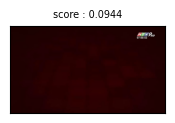

------------------ low_information images ------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



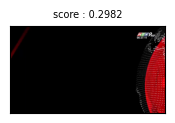

[]
len check: 0
Cleaning service: 2
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V022
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1530 [00:00<?, ?it/s]

  0%|          | 0/1530 [00:00<?, ?it/s]

Issue checks completed. 2 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | low_information  |            1 |
|  2 | blurry           |            0 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



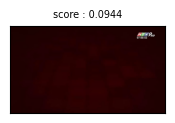

------------------ low_information images ------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



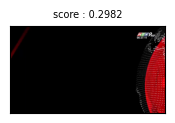

[]
len check: 0
Cleaning service: 3
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V022
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1530 [00:00<?, ?it/s]

  0%|          | 0/1530 [00:00<?, ?it/s]

Issue checks completed. 2 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | low_information  |            1 |
|  2 | blurry           |            0 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



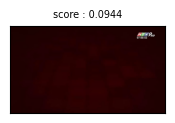

------------------ low_information images ------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



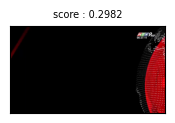

[]
len check: 0
Cleaning service: 1
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V023
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1293 [00:00<?, ?it/s]

  0%|          | 0/1293 [00:00<?, ?it/s]

Issue checks completed. 0 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | blurry           |            0 |
|  1 | dark             |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

[]
len check: 0
Cleaning service: 2
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V023
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1293 [00:00<?, ?it/s]

  0%|          | 0/1293 [00:00<?, ?it/s]

Issue checks completed. 0 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | blurry           |            0 |
|  1 | dark             |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

[]
len check: 0
Cleaning service: 3
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V023
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1293 [00:00<?, ?it/s]

  0%|          | 0/1293 [00:00<?, ?it/s]

Issue checks completed. 0 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | blurry           |            0 |
|  1 | dark             |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

[]
len check: 0
Cleaning service: 1
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V024
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1113 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Issue checks completed. 4 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | near_duplicates  |            3 |
|  1 | dark             |            1 |
|  2 | blurry           |            0 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | low_information  |            0 |
|  6 | odd_aspect_ratio |            0 |
|  7 | odd_size         |            0 |
|  8 | exact_duplicates |            0 | 

------------------ near_duplicates images ------------------

Number of examples with this issue: 3
Examples representing most severe instances of this issue:

Set: 0


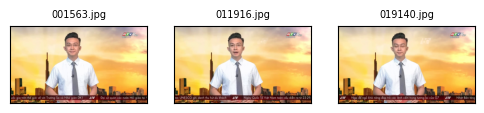

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



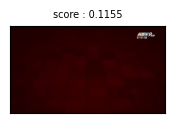

['/content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V024/001563.jpg', '/content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V024/019140.jpg']
len check: 2
Deleted image: /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V024/011916.jpg
Cleaning service: 2
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V024
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

Issue checks completed. 3 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | near_duplicates  |            2 |
|  1 | dark             |            1 |
|  2 | blurry           |            0 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | low_information  |            0 |
|  6 | odd_aspect_ratio |            0 |
|  7 | odd_size         |            0 |
|  8 | exact_duplicates |            0 | 

------------------ near_duplicates images ------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:

Set: 0


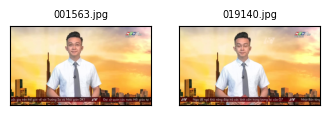

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



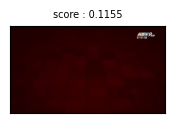

['/content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V024/001563.jpg']
len check: 1
Deleted image: /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V024/019140.jpg
Cleaning service: 3
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V024
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Issue checks completed. 1 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | blurry           |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



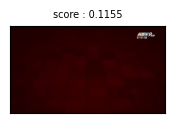

[]
len check: 0
Cleaning service: 1
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V025
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1188 [00:00<?, ?it/s]

  0%|          | 0/1188 [00:00<?, ?it/s]

Issue checks completed. 3 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | low_information  |            2 |
|  1 | dark             |            1 |
|  2 | blurry           |            0 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

------------------ low_information images ------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:



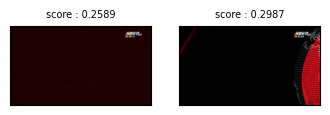

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



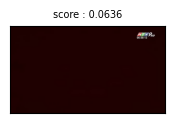

[]
len check: 0
Cleaning service: 2
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V025
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1188 [00:00<?, ?it/s]

  0%|          | 0/1188 [00:00<?, ?it/s]

Issue checks completed. 3 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | low_information  |            2 |
|  1 | dark             |            1 |
|  2 | blurry           |            0 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

------------------ low_information images ------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:



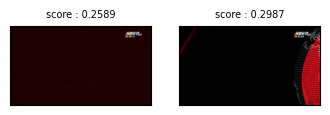

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



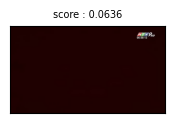

[]
len check: 0
Cleaning service: 3
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V025
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1188 [00:00<?, ?it/s]

  0%|          | 0/1188 [00:00<?, ?it/s]

Issue checks completed. 3 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | low_information  |            2 |
|  1 | dark             |            1 |
|  2 | blurry           |            0 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

------------------ low_information images ------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:



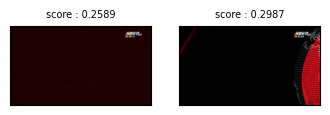

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



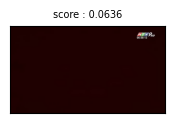

[]
len check: 0
Cleaning service: 1
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V026
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/940 [00:00<?, ?it/s]

Issue checks completed. 5 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | near_duplicates  |            2 |
|  1 | blurry           |            1 |
|  2 | dark             |            1 |
|  3 | low_information  |            1 |
|  4 | grayscale        |            0 |
|  5 | light            |            0 |
|  6 | odd_aspect_ratio |            0 |
|  7 | odd_size         |            0 |
|  8 | exact_duplicates |            0 | 

------------------ near_duplicates images ------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:

Set: 0


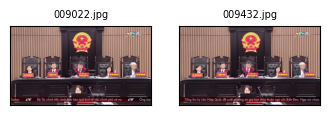

---------------------- blurry images -----------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



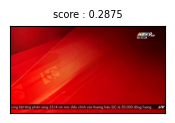

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



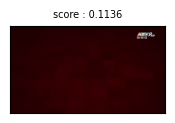

------------------ low_information images ------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



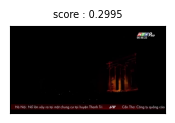

['/content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V026/009022.jpg']
len check: 1
Deleted image: /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V026/009432.jpg
Cleaning service: 2
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V026
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/939 [00:00<?, ?it/s]

  0%|          | 0/939 [00:00<?, ?it/s]

Issue checks completed. 3 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | blurry           |            1 |
|  1 | dark             |            1 |
|  2 | low_information  |            1 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

---------------------- blurry images -----------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



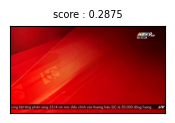

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



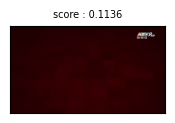

------------------ low_information images ------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



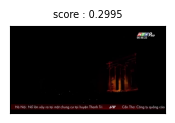

[]
len check: 0
Cleaning service: 3
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V026
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/939 [00:00<?, ?it/s]

  0%|          | 0/939 [00:00<?, ?it/s]

Issue checks completed. 3 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | blurry           |            1 |
|  1 | dark             |            1 |
|  2 | low_information  |            1 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

---------------------- blurry images -----------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



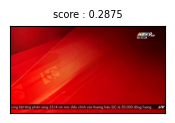

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



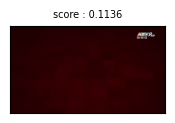

------------------ low_information images ------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



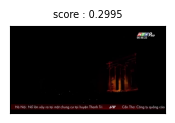

[]
len check: 0
Cleaning service: 1
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V027
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

Issue checks completed. 1 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | blurry           |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



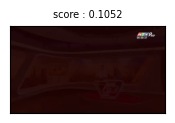

[]
len check: 0
Cleaning service: 2
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V027
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

Issue checks completed. 1 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | blurry           |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



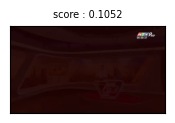

[]
len check: 0
Cleaning service: 3
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V027
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

Issue checks completed. 1 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | blurry           |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



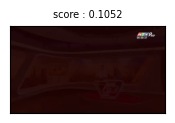

[]
len check: 0
Cleaning service: 1
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V028
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/1197 [00:00<?, ?it/s]

Issue checks completed. 1 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | blurry           |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



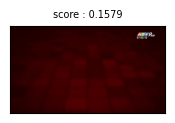

[]
len check: 0
Cleaning service: 2
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V028
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/1197 [00:00<?, ?it/s]

Issue checks completed. 1 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | blurry           |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



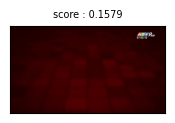

[]
len check: 0
Cleaning service: 3
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V028
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/1197 [00:00<?, ?it/s]

Issue checks completed. 1 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | blurry           |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



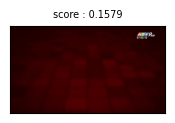

[]
len check: 0
Cleaning service: 1
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V029
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1044 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Issue checks completed. 2 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | near_duplicates  |            2 |
|  1 | blurry           |            0 |
|  2 | dark             |            0 |
|  3 | grayscale        |            0 |
|  4 | light            |            0 |
|  5 | low_information  |            0 |
|  6 | odd_aspect_ratio |            0 |
|  7 | odd_size         |            0 |
|  8 | exact_duplicates |            0 | 

------------------ near_duplicates images ------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:

Set: 0


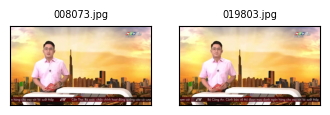

['/content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V029/008073.jpg']
len check: 1
Deleted image: /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V029/019803.jpg
Cleaning service: 2
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V029
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1043 [00:00<?, ?it/s]

  0%|          | 0/1043 [00:00<?, ?it/s]

Issue checks completed. 0 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | blurry           |            0 |
|  1 | dark             |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

[]
len check: 0
Cleaning service: 3
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V029
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1043 [00:00<?, ?it/s]

  0%|          | 0/1043 [00:00<?, ?it/s]

Issue checks completed. 0 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | blurry           |            0 |
|  1 | dark             |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

[]
len check: 0
Cleaning service: 1
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V030
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1211 [00:00<?, ?it/s]

  0%|          | 0/1211 [00:00<?, ?it/s]

Issue checks completed. 1 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | blurry           |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



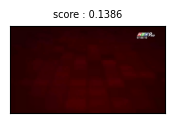

[]
len check: 0
Cleaning service: 2
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V030
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1211 [00:00<?, ?it/s]

  0%|          | 0/1211 [00:00<?, ?it/s]

Issue checks completed. 1 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | blurry           |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



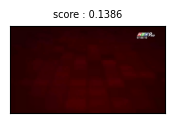

[]
len check: 0
Cleaning service: 3
Reading images from /content/drive/MyDrive/src/AIC2023/TransNetV2/results/Key_frame_L09/L09_V030
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1211 [00:00<?, ?it/s]

  0%|          | 0/1211 [00:00<?, ?it/s]

Issue checks completed. 1 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            1 |
|  1 | blurry           |            0 |
|  2 | grayscale        |            0 |
|  3 | light            |            0 |
|  4 | low_information  |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



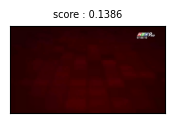

[]
len check: 0


In [ ]:
from cleanvision import Imagelab

for path in paths:
    for i in range(3):
        print(f"Cleaning service: {i+1}")
        # Specify path to folder containing the image files in your dataset
        imagelab = Imagelab(data_path=path)

        # Automatically check for a predefined list of issues within your dataset
        imagelab.find_issues()

        # Produce a neat report of the issues found in your dataset
        imagelab.report()

        image_clean = imagelab.issues.query("is_near_duplicates_issue")
        # visualize the given image files
        # imagelab.visualize(image_files=image_clean.index.tolist())

        check = image_clean.index.tolist()[::2]
        print(check)
        print(f"len check: {len(check)}")

        remove_images_not_in_keep_list(image_clean.index.tolist(), check)

In [ ]:
# image_clean = imagelab.issues.query("is_near_duplicates_issue")
# visualize the given image files
# imagelab.visualize(image_files=image_clean.index.tolist())

In [ ]:
print(image_clean.index.tolist())
print(len(image_clean.index.tolist()))

In [ ]:
check = image_clean.index.tolist()[::2]
print(check)
print(len(check))

In [ ]:
remove_images_not_in_keep_list(image_clean.index.tolist(), check)

## Renaming

## others

In [ ]:
!tail --bytes 1000 /content/drive/MyDrive/src/AIC2023/InternVideo/Pretrain/Multi-Modalities-Pretraining/dict/videos_id_path.json

, "1960": "/content/drive/MyDrive/src/AIC2023/CLIP4Clip/msvd_data/MSVD_Videos/zkTn5Ef1Oig_71_75.avi", "1961": "/content/drive/MyDrive/src/AIC2023/CLIP4Clip/msvd_data/MSVD_Videos/zlS1_zBYluY_15_21.avi", "1962": "/content/drive/MyDrive/src/AIC2023/CLIP4Clip/msvd_data/MSVD_Videos/zpgW7m7_LZw_2_15.avi", "1963": "/content/drive/MyDrive/src/AIC2023/CLIP4Clip/msvd_data/MSVD_Videos/zr9OeyfLPPY_4_9.avi", "1964": "/content/drive/MyDrive/src/AIC2023/CLIP4Clip/msvd_data/MSVD_Videos/zuYZ5kPatJE_78_116.avi", "1965": "/content/drive/MyDrive/src/AIC2023/CLIP4Clip/msvd_data/MSVD_Videos/zulPFoY64wE_26_33.avi", "1966": "/content/drive/MyDrive/src/AIC2023/CLIP4Clip/msvd_data/MSVD_Videos/zv2RIbUsnSw_159_162.avi", "1967": "/content/drive/MyDrive/src/AIC2023/CLIP4Clip/msvd_data/MSVD_Videos/zv2RIbUsnSw_335_341.avi", "1968": "/content/drive/MyDrive/src/AIC2023/CLIP4Clip/msvd_data/MSVD_Videos/zxB4dFJhHR8_1_9.avi", "1969": "/content/drive/MyDrive/src/AIC2023/CLIP4Clip/msvd_data/MSVD_Videos/zzit5b_-ukg_5_20.avi"}

In [ ]:
!pip install